# Credit Risk Analytics -Build a Scorecard Model

## Story
Given a Freddie Mac mortgage dataset corresponding to 2M loans between 2014 and 2018. Build a scorecard model that models the PD of individual loans using WOE and IV. Compare the model with Random Forest and XGBoosting.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
!pip install scorecardpy
import scorecardpy as sc
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/home/jovyan/work/BA/cw2'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/home/jovyan/work/BA/cw2/df_p5.csv
/home/jovyan/work/BA/cw2/q3.ipynb
/home/jovyan/work/BA/cw2/cw2kag.ipynb
/home/jovyan/work/BA/cw2/bins_adj.pkl
/home/jovyan/work/BA/cw2/train_woe.csv
/home/jovyan/work/BA/cw2/test_woe.csv
/home/jovyan/work/BA/cw2/Lab_6_Logistic_Regression_and_Scorecards.ipynb
/home/jovyan/work/BA/cw2/freddie_data_xgb_cv.pkl
/home/jovyan/work/BA/cw2/FiveYearData.csv
/home/jovyan/work/BA/cw2/bins_adj.npy
/home/jovyan/work/BA/cw2/freddie_data_rf.pkl
/home/jovyan/work/BA/cw2/freddie_data.pkl
/home/jovyan/work/BA/cw2/.ipynb_checkpoints/Lab_6_Logistic_Regression_and_Scorecards-checkpoint.ipynb
/home/jovyan/work/BA/cw2/.ipynb_checkpoints/q3-checkpoint.ipynb
/home/jovyan/work/BA/cw2/.ipynb_checkpoints/cw2kag-checkpoint.ipynb


## Step 1: Dataset cleaning

In [2]:
freddie_data = pd.read_csv('/home/jovyan/work/BA/cw2/FiveYearData.csv')

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (30,33,34,50,51) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# setting up viz packages
# !pip install seaborn --upgrade

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.__version__

'0.11.0'

In [4]:
# Convert date columns from int to date

date_cols = ['dt_first_pi', 'dt_matr', 'dt_orig', 'svcg_cycle', 'dt_zero_bal', 'dt_lst_pi']
freddie_data[date_cols] = pd.to_datetime(freddie_data[date_cols].stack(), format='%Y%m').unstack()

In [82]:
origination_cols = ['fico', 'dt_first_pi', 'flag_fthb', 'dt_matr',
       'cd_msa', 'mi_pct', 'cnt_units', 'occpy_sts', 'cltv', 'dti', 'orig_upb',
       'ltv', 'int_rt', 'channel', 'ppmt_pnlty', 'prod_type', 'st',
       'prop_type', 'zipcode', 'loan_purpose', 'orig_loan_term', 'cnt_borr',
       'seller_name', 'servicer_name', 'flag_sc', 'Default']

- fico: CREDIT SCORE • 301 - 850 • 9999 = Not Available, if Credit Score is < 301 or > 850.
- dt_first_pi: FIRST PAYMENT DATE
- flag_fthb:FIRST TIME HOMEBUYER FLAG Y = Yes N = No 9 = Not Available or Not Applicable
- dt_matr: MATURITY DATE
- cd_msa: METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION  Space (5) = Indicates that the area in whichthe mortgagedproperty is located is a) neither an MSA nor a Metropolitan - Division, or b) unknown.
- mi_pct: MORTGAGE INSURANCE PERCENTAGE (MI %), MORTGAGE INSURANCE PERCENTAGE (MI %)The percentage of loss coverage on the loan • 1% - 55% • 000 = No MI • 999 = N/A
- cnt_units: NUMBER OF UNITS - Denotes whether the mortgage is a one-, two-, three-, or four-unit property. • 99 = N/A
- occpy_sts: OCCUPANCY STATUS • P = Primary Residence • I = Investment Property • S = Second Home • 9 = N/A
- cltv: ORIGINAL COMBINED LOAN-TO-VALUE (CLTV) (the original mortgage loan amount + any secondary mortgage loan amount) / min(property’s appraised value,purchase price) • 0% - 200% • 999 = N/A
- dti: ORIGINAL DEBT-TO-INCOME (DTI) RATIO • 0%<DTI<=65% • 999 = Not Available
- orig_upb: The UPB (Unpaid Principal Balance) of the mortgage on the note date.
- ltv: ORIGINAL LOAN-TO-VALUE (LTV): the original mortgage loan amount / min(property’s appraised value,purchase price) • 6% - 105% • 999 = N/A
- int_rt: ORIGINAL INTEREST RATE
- channel: whether a Broker or Correspondent originated or was involved in the origination of the mortgage loan.• R = Retail • B = Broker • C = Correspondent • T = TPO Not Specified • 9 = N/A
- ppmt_pnlty: PREPAYMENT PENALTY MORTGAGE (PPM) FLAG • Y = PPM • N = Not PPM
- prod_type: Denotes that the product is a fixed-rate mortgage.• FRM – Fixed Rate Mortgage
- st: PROPERTY STATE
- prop_type: PROPERTY TYPE
- zipcode
- loan_purpose: • P = Purchase • C = Refinance - CashOut • N = Refinance - No CashOut • R = Refinance - Not Specified • 9 =Not Available
- orig_loan_term: based on the First Payment Date and Maturity Date.
- cnt_borr: NUMBER OF BORROWERS who are obligated to repay the mortgage• 01 = 1 borrower • 02 = > 1 borrowers • 99 = N/A
- seller_name: Name of the seller, or “Other Sellers”
- servicer_name: Name of the servicer, or “Other Servicers”
- flag_sc: SUPER CONFORMING FLAG – For mortgages that exceed conforming loan limits with origination dates on or after 10/1/2008 and settlements on or after 1/1/2009 • Y = Yes • Space (1) = Not Super Conforming

In [83]:
freddie_data[origination_cols].corr()
# cltv has high correlation to ltv as well as mi_pct. consider ignore it

,fico,cd_msa,mi_pct,cnt_units,cltv,dti,orig_upb,ltv,int_rt,orig_loan_term,cnt_borr,Default
fico,1.0000,0.0064,-0.0442,0.0092,-0.0738,-0.1564,0.0335,-0.0769,-0.2256,-0.0349,-0.0351,-0.1414
cd_msa,0.0064,1.0000,-0.0170,-0.0161,-0.0335,0.0519,0.1575,-0.0375,0.0230,0.0463,-0.0154,-0.0013
mi_pct,-0.0442,-0.0170,1.0000,-0.0742,0.5998,0.0535,0.0514,0.6347,0.1183,0.2322,-0.0222,0.0420
cnt_units,0.0092,-0.0161,-0.0742,1.0000,-0.0723,0.0240,0.0739,-0.0737,0.0910,0.0125,-0.0157,-0.0010
cltv,-0.0738,-0.0335,0.5998,-0.0723,1.0000,0.0666,0.1292,0.9501,0.1814,0.2728,-0.0221,0.0396
dti,-0.1564,0.0519,0.0535,0.0240,0.0666,1.0000,0.1255,0.0682,0.1495,0.1225,-0.0856,0.0530
orig_upb,0.0335,0.1575,0.0514,0.0739,0.1292,0.1255,1.0000,0.1140,-0.0189,0.1839,0.1355,-0.0191
ltv,-0.0769,-0.0375,0.6347,-0.0737,0.9501,0.0682,0.1140,1.0000,0.1916,0.2831,-0.0286,0.0414
int_rt,-0.2256,0.0230,0.1183,0.0910,0.1814,0.1495,-0.0189,0.1916,1.0000,0.5402,-0.0574,0.0485
orig_loan_term,-0.0349,0.0463,0.2322,0.0125,0.2728,0.1225,0.1839,0.2831,0.5402,1.0000,-0.0442,0.0311


In [7]:
freddie_data[origination_cols].isnull().any()

fico              False
dt_first_pi       False
flag_fthb         False
dt_matr           False
cd_msa             True
mi_pct            False
cnt_units         False
occpy_sts         False
cltv              False
dti               False
orig_upb          False
ltv               False
int_rt            False
channel           False
ppmt_pnlty         True
prod_type         False
st                False
prop_type         False
zipcode            True
loan_purpose      False
orig_loan_term    False
cnt_borr          False
seller_name       False
servicer_name     False
flag_sc            True
Default           False
dtype: bool

In [8]:
pd.options.display.float_format = '{:.4f}'.format
freddie_data[origination_cols].describe()

# too many 9s spotted

,fico,cd_msa,mi_pct,cnt_units,cltv,dti,orig_upb,ltv,int_rt,zipcode,orig_loan_term,cnt_borr
count,2098593.0000,1888545.0000,2098593.0000,2098593.0000,2098593.0000,2098593.0000,2098593.0000,2098593.0000,2098593.0000,2098588.0000,2098593.0000,2098593.0000
mean,750.2470,30315.1882,6.5125,1.0321,74.3620,34.4936,233156.4591,73.9396,4.1369,56153.6148,322.6556,1.5008
std,97.4986,11235.6177,11.6879,0.2499,17.1065,11.3479,120928.7006,17.1695,0.5628,29760.8378,71.5817,0.5000
min,517.0000,10180.0000,0.0000,1.0000,6.0000,1.0000,6000.0000,6.0000,2.2500,600.0000,60.0000,1.0000
25%,717.0000,19430.0000,0.0000,1.0000,67.0000,28.0000,140000.0000,66.0000,3.7500,30500.0000,360.0000,1.0000
50%,758.0000,31700.0000,0.0000,1.0000,80.0000,36.0000,210000.0000,79.0000,4.1250,55400.0000,360.0000,2.0000
75%,787.0000,40060.0000,12.0000,1.0000,85.0000,42.0000,309000.0000,83.0000,4.5000,84600.0000,360.0000,2.0000
max,9999.0000,49740.0000,999.0000,99.0000,999.0000,999.0000,1285000.0000,999.0000,7.0000,99900.0000,549.0000,2.0000


In [9]:
# display cols with null count. Next, clean the dataset with null schema described in the data use guideline.

null_cols = freddie_data[origination_cols].isnull().any()
freddie_data[origination_cols].isnull().sum()

fico                    0
dt_first_pi             0
flag_fthb               0
dt_matr                 0
cd_msa             210048
mi_pct                  0
cnt_units               0
occpy_sts               0
cltv                    0
dti                     0
orig_upb                0
ltv                     0
int_rt                  0
channel                 0
ppmt_pnlty           1307
prod_type               0
st                      0
prop_type               0
zipcode                 5
loan_purpose            0
orig_loan_term          0
cnt_borr                0
seller_name             0
servicer_name           0
flag_sc           2011435
Default                 0
dtype: int64

In [10]:
freddie_data['Default'] = np.where(freddie_data['Default'] == 'YES', 1, 0)

In [11]:
# Credit score 9999 is N/A
freddie_data['fico'] = freddie_data['fico'].astype('float')
freddie_data.fico.values[freddie_data.fico.values == 9999] = np.NaN

In [12]:
# cd_msa NaN is 'not in MSA/MD/Unknown'
freddie_data['cd_msa'].fillna(value=00000, inplace=True)

In [13]:
# mi_pct 999 is N/A
freddie_data['mi_pct'] = freddie_data['mi_pct'].astype('float')
freddie_data.mi_pct.values[freddie_data.mi_pct.values == 999] = np.NaN

In [14]:
# cnt_units 99 is N/A
freddie_data['cnt_units'] = freddie_data['cnt_units'].astype('float')
freddie_data.cnt_units.values[freddie_data.cnt_units.values == 99] = np.NaN

In [15]:
# occpy_sts 9 is N/A
freddie_data.occpy_sts.values[freddie_data.occpy_sts.values == 9] = np.NaN

In [16]:
# dti 999 is N/A
freddie_data['dti'] = freddie_data['dti'].astype('float')
freddie_data.dti.values[freddie_data.dti.values == 999] = np.NaN

In [17]:
# ltv 999 is N/A. 
freddie_data['ltv'] = freddie_data['ltv'].astype('float')
freddie_data.ltv.values[freddie_data.ltv.values == 999] = np.NaN

In [18]:
# channel 9 is N/A
freddie_data.channel.values[freddie_data.channel.values == 9] = np.NaN

In [19]:
# prop_type 99 is N/A
freddie_data.prop_type.values[freddie_data.prop_type.values == 99] = np.NaN

In [20]:
# loan_purpose 9 is N/A
freddie_data.loan_purpose.values[freddie_data.loan_purpose.values == 9] = np.NaN

In [21]:
# cnt_borr 99 is N/A
freddie_data['cnt_borr'] = freddie_data['cnt_borr'].astype('float')
freddie_data.cnt_borr.values[freddie_data.cnt_borr.values == 99] = np.NaN

In [22]:
# flag_sc NaN is 'not super conforming'
freddie_data['flag_sc'].fillna(value='N', inplace=True)

In [23]:
# display the result after cleaning

null_cols = freddie_data[origination_cols].isnull().any()
freddie_data[origination_cols].isnull().sum()

fico               183
dt_first_pi          0
flag_fthb            0
dt_matr              0
cd_msa               0
mi_pct               4
cnt_units            1
occpy_sts            0
cltv                 0
dti                 91
orig_upb             0
ltv                 51
int_rt               0
channel              0
ppmt_pnlty        1307
prod_type            0
st                   0
prop_type            0
zipcode              5
loan_purpose         0
orig_loan_term       0
cnt_borr             0
seller_name          0
servicer_name        0
flag_sc              0
Default              0
dtype: int64

In [24]:
# take a look at rows w/ fico being null.

freddie_data.loc[freddie_data['fico'].isnull()]

,Unnamed: 0,id_loan,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,...,taxes_ins_costs,misc_costs,actual_loss,modcost,stepmod_ind,dpm_ind,eltv,zb_removal_upb,dlq_acrd_int,Default
40116,40116,F114Q1116808,nan,2014-05-01,Y,2044-04-01,14740.0000,0.0000,1.0000,P,...,nan,nan,nan,nan,NaN,NaN,nan,nan,nan,0
49124,49124,F114Q1143145,nan,2014-04-01,N,2034-03-01,40380.0000,0.0000,1.0000,P,...,nan,nan,nan,nan,NaN,NaN,nan,nan,nan,0
51460,51460,F114Q1149982,nan,2014-04-01,Y,2029-03-01,26420.0000,0.0000,1.0000,P,...,nan,nan,nan,nan,NaN,NaN,nan,nan,nan,0
61208,61208,F114Q2005650,nan,2014-06-01,Y,2029-05-01,0.0000,0.0000,1.0000,P,...,nan,nan,nan,nan,NaN,NaN,nan,nan,nan,0
66141,66141,F114Q2020023,nan,2014-07-01,Y,2044-06-01,0.0000,25.0000,1.0000,P,...,nan,nan,nan,nan,NaN,NaN,nan,nan,nan,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075529,2075529,F118Q4175561,nan,2019-01-01,Y,2048-12-01,38860.0000,0.0000,1.0000,P,...,nan,nan,nan,nan,NaN,NaN,nan,nan,nan,0
2077731,2077731,F118Q4182152,nan,2019-01-01,N,2048-12-01,19124.0000,0.0000,1.0000,P,...,nan,nan,nan,nan,NaN,NaN,nan,nan,nan,0
2081979,2081979,F118Q4194869,nan,2019-02-01,Y,2034-01-01,45460.0000,0.0000,1.0000,P,...,nan,nan,nan,nan,NaN,NaN,nan,nan,nan,0
2092631,2092631,F118Q4226738,nan,2019-02-01,9,2049-01-01,0.0000,0.0000,1.0000,P,...,nan,nan,nan,nan,NaN,NaN,nan,nan,nan,0


In [25]:
# Since missing values do not account for more than 1% for any of the columns
# numeric columns missings are replaced with column median.
num_mean = freddie_data[origination_cols].select_dtypes(include='number').median()
for i in freddie_data[origination_cols].select_dtypes(include='number').columns:
    freddie_data[i].fillna(num_mean.loc[i], inplace=True)

# categorical columns missings are replaced with column mode.
cat_mode = freddie_data[origination_cols].select_dtypes(include='object').mode().iloc[0]
for j in freddie_data[origination_cols].select_dtypes(include='object').columns:
    freddie_data[j].fillna(cat_mode.loc[j], inplace=True)

# dt_orig missing are calculated as 2 months before dt_first_pi (As with the most cases).
# freddie_data['dt_orig'].fillna(pd.to_datetime(freddie_data['dt_first_pi'] - pd.DateOffset(months=2)), inplace=True)

In [26]:
freddie_data[origination_cols].isnull().sum()

fico              0
dt_first_pi       0
flag_fthb         0
dt_matr           0
cd_msa            0
mi_pct            0
cnt_units         0
occpy_sts         0
cltv              0
dti               0
orig_upb          0
ltv               0
int_rt            0
channel           0
ppmt_pnlty        0
prod_type         0
st                0
prop_type         0
zipcode           0
loan_purpose      0
orig_loan_term    0
cnt_borr          0
seller_name       0
servicer_name     0
flag_sc           0
Default           0
dtype: int64

In [27]:
# Generate a coarser segmentation of zipcode.
freddie_data['zipcode'] = freddie_data['zipcode'].astype('str')
conditions = [
    freddie_data['zipcode'].str.startswith('0'),
    freddie_data['zipcode'].str.startswith('1'),
    freddie_data['zipcode'].str.startswith('2'),
    freddie_data['zipcode'].str.startswith('3'),
    freddie_data['zipcode'].str.startswith('4'),
    freddie_data['zipcode'].str.startswith('5'),
    freddie_data['zipcode'].str.startswith('6'),
    freddie_data['zipcode'].str.startswith('7'),
    freddie_data['zipcode'].str.startswith('8'),
    freddie_data['zipcode'].str.startswith('9')]
choices = ['NewEngland', 'TheEast', 'Atlantic', 'SouthEast', 'TheGreatLakes', 
          'TheNorth', 'TheMid', 'TheSouth', 'TheDesert', 'Pacific']
freddie_data['Area'] = np.select(conditions, choices, default=np.nan)

- As the map shows, the zip code shows a geographic pattern, therefore transfer zipcode into a coarser variable. In the meantime, state variable can be removed.

![Image of zipcode map of USA](https://stevemorse.org/jcal/zipwiki.jpg)


In [28]:
pd.options.display.float_format = '{:.4f}'.format
freddie_data[origination_cols].describe()

# After, substituting 9s, no significant outliers spotted for columns with a continous distribution

,fico,cd_msa,mi_pct,cnt_units,cltv,dti,orig_upb,ltv,int_rt,orig_loan_term,cnt_borr,Default
count,2098593.0000,2098593.0000,2098593.0000,2098593.0000,2098593.0000,2098593.0000,2098593.0000,2098593.0000,2098593.0000,2098593.0000,2098593.0000,2098593.0000
mean,749.4412,27280.9435,6.5106,1.0321,74.3620,34.4519,233156.4591,73.9172,4.1369,322.6556,1.5008,0.0244
std,45.2346,14013.5982,11.6073,0.2406,17.1065,9.4040,120928.7006,16.5528,0.5628,71.5817,0.5000,0.1543
min,517.0000,0.0000,0.0000,1.0000,6.0000,1.0000,6000.0000,6.0000,2.2500,60.0000,1.0000,0.0000
25%,717.0000,16974.0000,0.0000,1.0000,67.0000,28.0000,140000.0000,66.0000,3.7500,360.0000,1.0000,0.0000
50%,758.0000,29820.0000,0.0000,1.0000,80.0000,36.0000,210000.0000,79.0000,4.1250,360.0000,2.0000,0.0000
75%,787.0000,38940.0000,12.0000,1.0000,85.0000,42.0000,309000.0000,83.0000,4.5000,360.0000,2.0000,0.0000
max,845.0000,49740.0000,50.0000,4.0000,999.0000,51.0000,1285000.0000,105.0000,7.0000,549.0000,2.0000,1.0000


In [29]:
Crosstab_servicer_name = pd.crosstab(freddie_data['servicer_name'], freddie_data['Default'])
Crosstab_servicer_name['Default ratio'] = Crosstab_servicer_name[1] / (Crosstab_servicer_name[1] + Crosstab_servicer_name[0])
Crosstab_servicer_name

Default,0,1,Default ratio
servicer_name,,,
"AMERIHOME MORTGAGE COMPANY, LLC",29104,837,0.0280
ARVEST CENTRAL MORTGAGE COMPANY,17863,345,0.0189
"AURORA FINANCIAL GROUP, INC.",8050,51,0.0063
"BANK OF AMERICA, N.A.",75587,537,0.0071
BRANCH BANKING & TRUST COMPANY,6323,225,0.0344
BRANCH BANKING AND TRUST COMPANY,52675,1086,0.0202
"CALIBER HOME LOANS, INC.",74203,1863,0.0245
CENTRAL MORTGAGE COMPANY,523,17,0.0315
"CITIMORTGAGE, INC.",3110,87,0.0272


In [30]:
Crosstab_seller_name = pd.crosstab(freddie_data['seller_name'], freddie_data['Default'])
Crosstab_seller_name['Default ratio'] = Crosstab_seller_name[1] / (Crosstab_seller_name[1] + Crosstab_seller_name[0])
Crosstab_seller_name

Default,0,1,Default ratio
seller_name,,,
"AMERIHOME MORTGAGE COMPANY, LLC",55186,1420,0.0251
"BANK OF AMERICA, N.A.",75604,1269,0.0165
BRANCH BANKING & TRUST COMPANY,65765,1516,0.0225
"CALIBER HOME LOANS, INC.",73979,3265,0.0423
"CITIMORTGAGE, INC.",15691,524,0.0323
"CITIZENS BANK, NA",3963,19,0.0048
"CMG MORTGAGE, INC.",1345,60,0.0427
COLE TAYLOR BANK,543,31,0.0540
FAIRWAY INDEPENDENT MORTGAGE CORPORATION,26871,541,0.0197


In [31]:
# A few similar names of entities indicating they may belong to a unique entity. Therefore combine them.

freddie_data.loc[freddie_data['servicer_name'] == 'BRANCH BANKING & TRUST COMPANY', 'servicer_name'] = 'BRANCH BANKING AND TRUST COMPANY'
freddie_data.loc[freddie_data['servicer_name'] == 'JPMORGAN CHASE BANK, N.A.', 'servicer_name'] = 'JPMORGAN CHASE BANK, NATIONAL ASSOCIATION'
freddie_data.loc[freddie_data['servicer_name'] == 'NATIONSTAR MORTGAGE LLC', 'servicer_name'] = 'NATIONSTAR MORTGAGE LLC DBA MR. COOPER'
freddie_data.loc[freddie_data['servicer_name'] == 'STEARNS LENDING, LLC', 'servicer_name'] = 'STEARNS LENDING, LLC.'
freddie_data.loc[freddie_data['servicer_name'] == 'SUNTRUST BANK', 'servicer_name'] = 'SUNTRUST MORTGAGE, INC.'

freddie_data.loc[freddie_data['seller_name'] == 'FIFTH THIRD BANK', 'seller_name'] = 'FIFTH THIRD MORTGAGE COMPANY'
freddie_data.loc[freddie_data['seller_name'] == 'JPMORGAN CHASE BANK, N.A.', 'seller_name'] = 'JPMORGAN CHASE BANK, NATIONAL ASSOCIATION'
freddie_data.loc[freddie_data['seller_name'] == 'NATIONSTAR MORTGAGE LLC', 'seller_name'] = 'NATIONSTAR MORTGAGE LLC DBA MR. COOPER'
freddie_data.loc[freddie_data['seller_name'] == 'PRIMELENDING A PLAINS CAPITAL CO', 'seller_name'] = 'PRIMELENDING, A PLAINSCAPITAL COMPANY'
freddie_data.loc[freddie_data['seller_name'] == 'STEARNS LENDING, INC.', 'seller_name'] = 'STEARNS LENDING, LLC.'
freddie_data.loc[freddie_data['seller_name'] == 'STEARNS LENDING, LLC', 'seller_name'] = 'STEARNS LENDING, LLC.'
freddie_data.loc[freddie_data['seller_name'] == 'SUNTRUST BANK', 'seller_name'] = 'SUNTRUST MORTGAGE, INC.'
freddie_data.loc[freddie_data['seller_name'] == 'UNITED SHORE FINANCIAL SERVICES, LLC, DBA UNITED WHOLESALE M', 'seller_name'] = 'UNITED SHORE FINANCIAL SERVICES, LLC'
freddie_data.loc[freddie_data['seller_name'] == 'UNITED SHORE FINANCIAL SERVICES, LLC., DBA SHORE MORTGAGE', 'seller_name'] = 'UNITED SHORE FINANCIAL SERVICES, LLC'
freddie_data.loc[freddie_data['seller_name'] == 'UNITED SHORE FINANCIAL SERVICES, LLC., DBA UNITED WHOLESALE', 'seller_name'] = 'UNITED SHORE FINANCIAL SERVICES, LLC'


# justify which variable are available before granting a loan to the borrower as if Freddie Mac is a bank
- fico: In. Can always retrieve.
- dt_first_pi: Out. not available since no payment has been made yet.
- flag_fthb: In. can always verify with the customer.
- dt_matr: Out. No loan is made yet.
- cd_msa: Out. Replaced by Area.
- mi_pct: Out. no mortgage insurance has been purchased prior to the granting the loan.
- cnt_units: In. Can always check.
- occpy_sts: In. Can always check.
- cltv: In. Can always check.
- dti: In. Can always check.
- orig_upb: Out. Not applicable.
- ltv: In. Can always check.
- int_rt: Out. As no decision has been made, no known interest rate, as if Freddie Mac is a bank.
- channel: In. Can always check.
- ppmt_pnlty: In. Can always check with bank's policy.
- prod_type: Out. As no decision has been made, no known loan type, as if Freddie Mac is a bank.
- st: Out. Use Area code instead.
- prop_type: In. Can always check.
- zipcode: Out. Use Area code instead.
- loan_purpose: In. Can always check.
- orig_loan_term: Out. No first payment date known.
- cnt_borr: In. Can always check.
- seller_name: In. Can always check. Use binned variable
- servicer_name: In. Can always check. Use binned variable
- flag_sc: In. a mark on whether the person lives somewhere designated as HCOL(are buying a very expensive house)

In [65]:
# justify which variable are available before grant a loan to the borrower as if Freddie Mac is a bank
origination_cols_final = ['fico', 'ltv', 'flag_fthb', 'cnt_units', 'occpy_sts', 'dti',
                          'channel', 'ppmt_pnlty', 'prop_type', 'loan_purpose',
                          'cnt_borr', 'servicer_name', 'seller_name', 'Area', 'flag_sc','Default']

In [172]:
freddie_data[origination_cols_final].describe()

,fico,cnt_units,ltv,dti,cnt_borr,Default
count,2098593.0000,2098593.0000,2098593.0000,2098593.0000,2098593.0000,2098593.0000
mean,749.4412,1.0321,73.9172,34.4519,1.5008,0.0244
std,45.2346,0.2406,16.5528,9.4040,0.5000,0.1543
min,517.0000,1.0000,6.0000,1.0000,1.0000,0.0000
25%,717.0000,1.0000,66.0000,28.0000,1.0000,0.0000
50%,758.0000,1.0000,79.0000,36.0000,2.0000,0.0000
75%,787.0000,1.0000,83.0000,42.0000,2.0000,0.0000
max,845.0000,4.0000,105.0000,51.0000,2.0000,1.0000


CPU times: user 21 s, sys: 9.65 s, total: 30.6 s
Wall time: 20.3 s


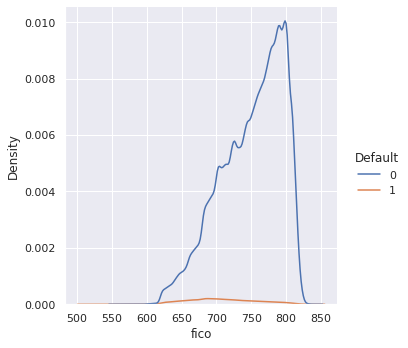

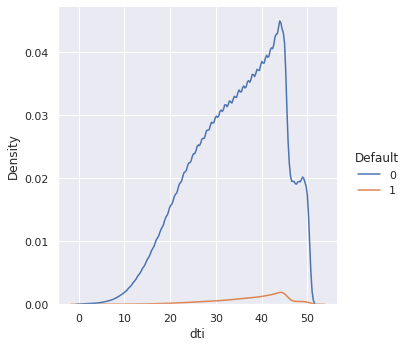

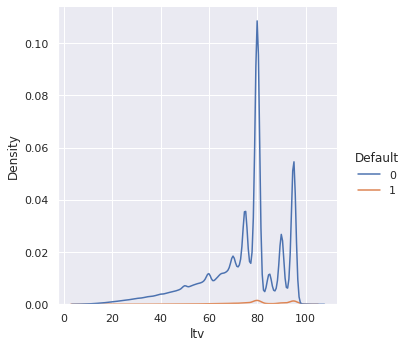

In [33]:
%%time

# plot kde for continous variable in the final list of origination variables.

sns.set(color_codes=True)

origination_cols_final_wdis = ['fico', 'dti', 'ltv']


for col_id in origination_cols_final_wdis:
    sns.displot(freddie_data, x = col_id, hue = "Default", kind = 'kde')

In [34]:
numeric_cols = freddie_data[origination_cols_final_wdis].select_dtypes(include=[np.number]).columns

In [35]:
freddie_data_normed = freddie_data[numeric_cols].apply(zscore)

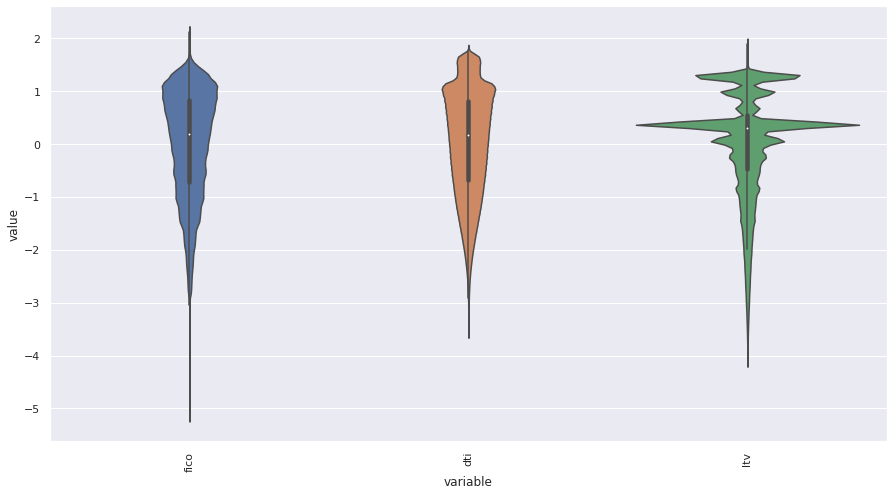

In [36]:
fig, ax = plt.subplots(figsize=(15,8))
a = sns.violinplot(x='variable', y='value', data=pd.melt(freddie_data_normed), ax=ax)
a.set_xticklabels(a.get_xticklabels(), rotation=90);

In [37]:
mnlypfm_cols = ['svcg_cycle', 'current_upb', 'delq_sts', 'loan_age', 'mths_remng', 'repch_flag',
       'flag_mod', 'cd_zero_bal', 'dt_zero_bal', 'current_int_rt',
       'non_int_brng_upb', 'dt_lst_pi', 'mi_recoveries', 'net_sale_proceeds',
       'non_mi_recoveries', 'expenses', 'legal_costs', 'maint_pres_costs',
       'taxes_ins_costs', 'misc_costs', 'actual_loss', 'modcost',
       'stepmod_ind', 'dpm_ind', 'eltv', 'zb_removal_upb', 'dlq_acrd_int']

- svcg_cycle: The as-of month for loan information contained in the loan record.
- current_upb: ending balance
- delq_sts: the number of days the borrower is delinquent [• XX = Unknown • 0 = Current, or less than 30 days past due • 1 = 30-59 days • 2 = 60 – 89  days • 3 = 90 – 119 • And so on… • R = REO Acquisition • Space (3) = Unavailable]
- loan_age: ((Monthly Reporting Period) – Loan Origination Date) – 1 month
- mths_remng: (Maturity Date(MM/YY) – Monthly Reporting Period
- repch_flag: • N = Not Repurchased • Y = Repurchased • Space (1) = N/A
- flag_mod: • Y = Yes • Space (1) = Not Modified
- cd_zero_bal: • 01 = Prepaid or Matured (Voluntary Payoff) • 02 = Third Party Sale • 03 = Short Sale or Charge Off • 06 = Repurchase prior to Property Disposition • 09 = REO Disposition • 15 = Note sale/Reperforming sale
- dt_zero_bal
- current_int_rt
- non_int_brng_upb: The current non-interest bearing UPB of the modified mortgage.
- dt_lst_pi: DUE DATE OF LAST PAID INSTALLMENT
- mi_recoveries: proceeds received by Freddie Mac in the event of credit losses.
- net_sale_proceeds: $ Amount. Gross Sale Proceeds – Allowable Selling Expenses. U = Unknown
- non_mi_recoveries
- expenses: an aggregation of Legal Costs, Maintenance and Preservation Costs, Taxes and Insurance, and Miscellaneous Expenses
- legal_costs
- maint_pres_costs
- taxes_ins_costs
- misc_costs
- actual_loss
- modcost
- stepmod_ind: denote if the terms of modification agreement call for note rate to increase over time.
- dpm_ind: indicate Deferred Payment Modification for the loan.
- eltv
- zb_removal_upb: The amount of total UPB remaining on the loan immediately prior to the application of the Zero Balance Code
- dlq_acrd_int: The amount of delinquent interest owed by the borrower at the time of default.

In [38]:
freddie_data[mnlypfm_cols].isnull().sum() #	2098593

svcg_cycle           2047362
current_upb          2047362
delq_sts             2047362
loan_age             2047362
mths_remng           2047362
repch_flag           2090377
flag_mod             2098446
cd_zero_bal          2090379
dt_zero_bal          2090379
current_int_rt       2047362
non_int_brng_upb     2047362
dt_lst_pi            2096221
mi_recoveries        2098574
net_sale_proceeds    2098574
non_mi_recoveries    2098574
expenses             2098574
legal_costs          2098574
maint_pres_costs     2098574
taxes_ins_costs      2098574
misc_costs           2098574
actual_loss          2098574
modcost              2089059
stepmod_ind          2098446
dpm_ind              2098446
eltv                 2076471
zb_removal_upb       2090379
dlq_acrd_int         2098574
dtype: int64

## Step 2: Calculate the WoE and perform the variable selection procedures

In [66]:
%%time
# Split in train and test BEFORE applying WoE
# Use  Student ID as seed!
train, test = sc.split_df(freddie_data[origination_cols_final],
                          y = 'Default',
                          ratio = 0.7, seed = 251121229).values()

CPU times: user 48.2 s, sys: 1.28 s, total: 49.5 s
Wall time: 49.4 s


In [67]:
# As we have more than 2 million records in our data set (1.4 million in the training set), it is  
# reasonable to have more binnings for better adaptation. Thus the min_perc_fine_bin is set to
# 0.01 (100 bins). We want to the results to be more representitive, therefore min_coarse_fine_bin is 
# set to 0.02 (20 bins). But the maximum number of bins is set to 8 so that on average each final bin 
# will have maximum  of 12.5% of all training data. Finally the stop limit of information value 
# is set to 0.1 to keep an appropriate number of predictors in the model.

bins = sc.woebin(train, y = 'Default', 
                 min_perc_fine_bin=0.01, # How many bins to cut initially into
                 min_perc_coarse_bin=0.02,  # Minimum percentage per final bin
                 stop_limit=0.1, # Minimum information value 
                 max_num_bin=8, # Maximum number of bins
                 positive='bad|1',
                 no_cores=8,
                 ignore_const_cols=True,
                 ignore_datetime_cols=True, 
                 check_cate_num=True,
                 replace_blank=True)

[INFO] creating woe binning ...


/opt/conda/lib/python3.8/site-packages/scorecardpy/condition_fun.py:19: UserWarning: There are 1 columns have only one unique values, which are removed from input dataset. 
 (ColumnNames: ppmt_pnlty)
  warnings.warn("There are {} columns have only one unique values, which are removed from input dataset. \n (ColumnNames: {})".format(len(unique1_cols), ', '.join(unique1_cols)))


Binning on 1469015 rows and 15 columns in 00:00:45


CPU times: user 495 ms, sys: 19.7 ms, total: 515 ms
Wall time: 509 ms


{'ltv': <Figure size 432x288 with 2 Axes>,
 'flag_fthb': <Figure size 432x288 with 2 Axes>,
 'loan_purpose': <Figure size 432x288 with 2 Axes>,
 'seller_name': <Figure size 432x288 with 2 Axes>,
 'Area': <Figure size 432x288 with 2 Axes>,
 'cnt_borr': <Figure size 432x288 with 2 Axes>,
 'fico': <Figure size 432x288 with 2 Axes>,
 'dti': <Figure size 432x288 with 2 Axes>,
 'cnt_units': <Figure size 432x288 with 2 Axes>,
 'prop_type': <Figure size 432x288 with 2 Axes>,
 'servicer_name': <Figure size 432x288 with 2 Axes>,
 'channel': <Figure size 432x288 with 2 Axes>,
 'flag_sc': <Figure size 432x288 with 2 Axes>,
 'occpy_sts': <Figure size 432x288 with 2 Axes>}

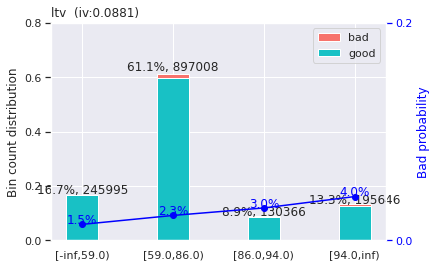

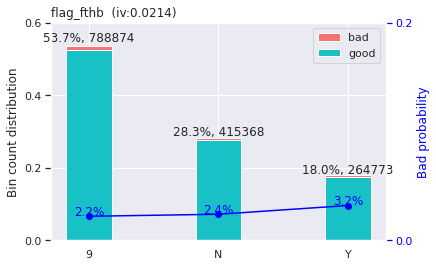

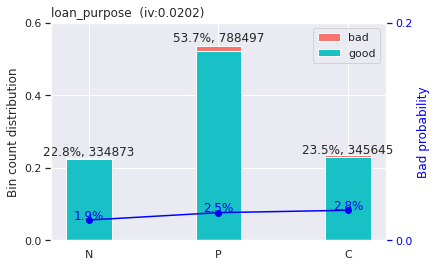

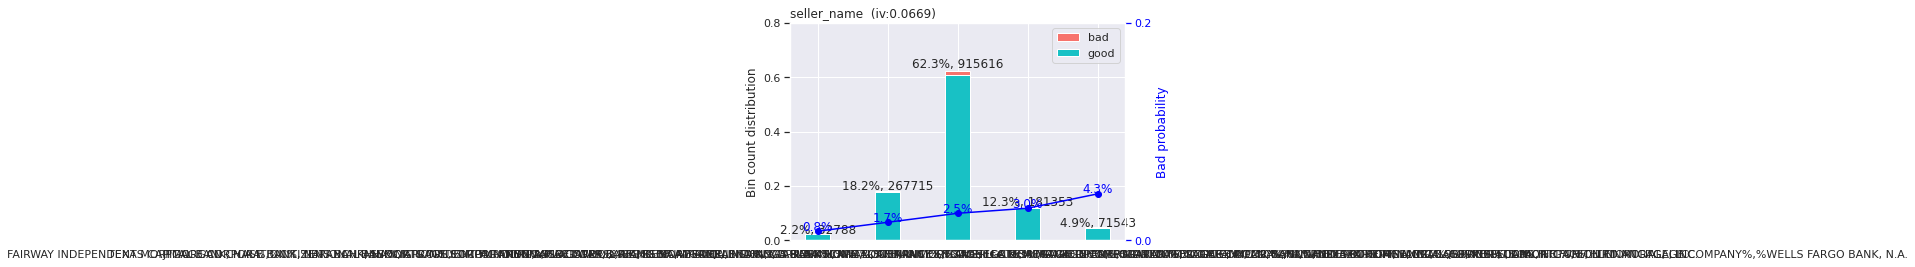

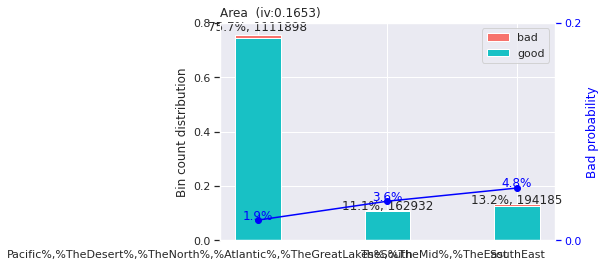

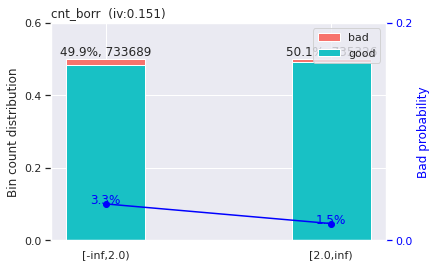

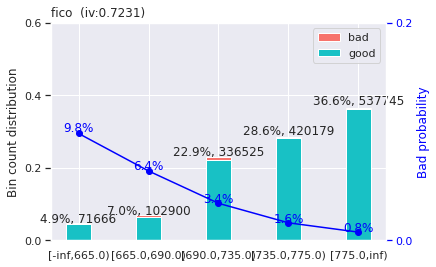

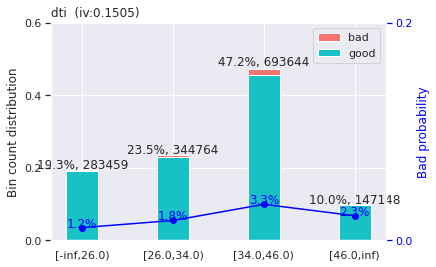

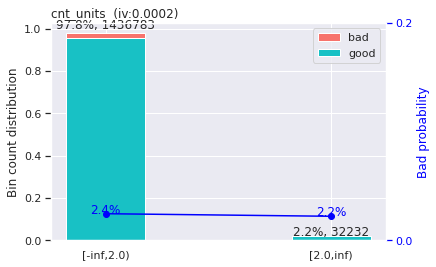

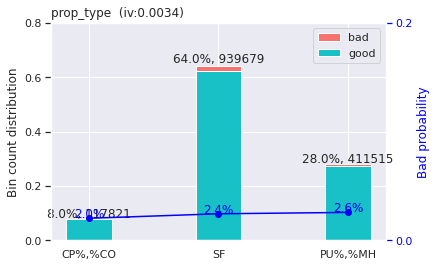

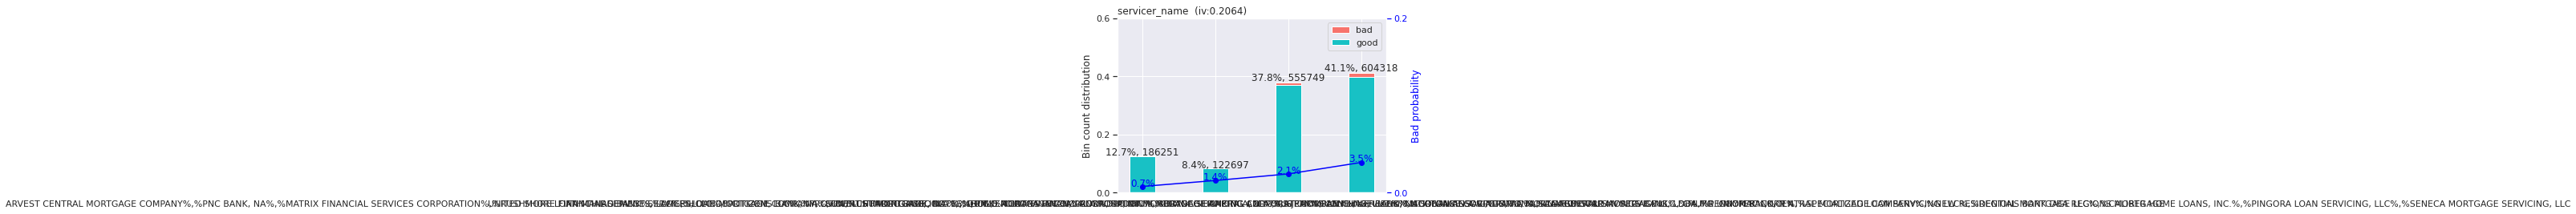

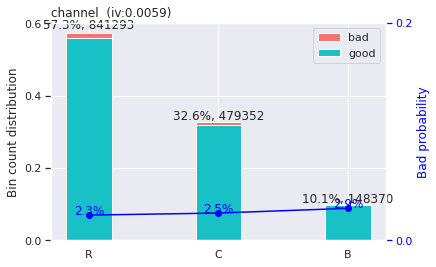

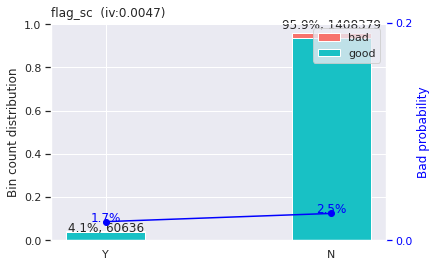

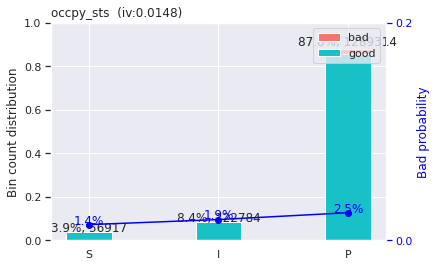

In [68]:
%%time
sc.woebin_plot(bins)

-------- 1/14 ltv --------
>>> dt[ltv].describe(): 
count   1469015.0000
mean         73.9110
std          16.5653
min           6.0000
25%          66.0000
50%          79.0000
75%          83.0000
max         103.0000
Name: ltv, dtype: float64 



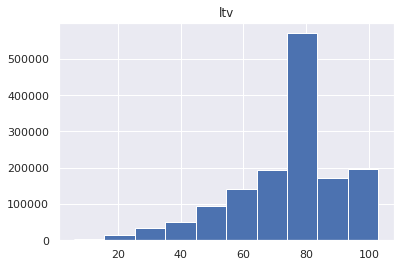

>>> Current breaks:
59.0,86.0,94.0 



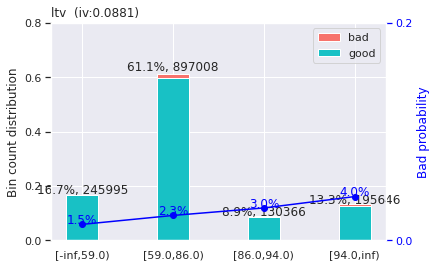

>>> Adjust breaks for (1/14) ltv?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/14 flag_fthb --------
>>> dt[flag_fthb].describe(): 
count     1469015
unique          3
top             9
freq       788874
Name: flag_fthb, dtype: object 

>>> dt[flag_fthb].value_counts(): 
9    788874
N    415368
Y    264773
Name: flag_fthb, dtype: int64 

>>> Current breaks:
'9','N','Y' 



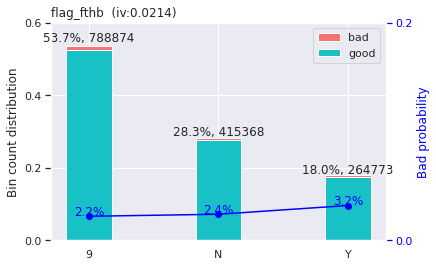

>>> Adjust breaks for (2/14) flag_fthb?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/14 loan_purpose --------
>>> dt[loan_purpose].describe(): 
count     1469015
unique          3
top             P
freq       788497
Name: loan_purpose, dtype: object 

>>> dt[loan_purpose].value_counts(): 
P    788497
C    345645
N    334873
Name: loan_purpose, dtype: int64 

>>> Current breaks:
'N','P','C' 



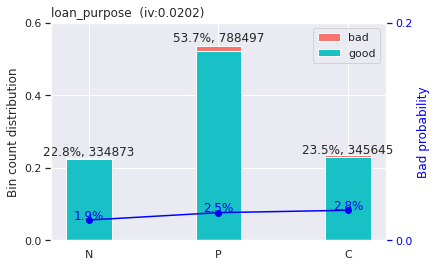

>>> Adjust breaks for (3/14) loan_purpose?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/14 seller_name --------
>>> dt[seller_name].describe(): 
count           1469015
unique               38
top       Other sellers
freq             545183
Name: seller_name, dtype: object 

>>> dt[seller_name].value_counts(): 
Other sellers                                  545183
WELLS FARGO BANK, N.A.                         189501
JPMORGAN CHASE BANK, NATIONAL ASSOCIATION       95891
QUICKEN LOANS INC.                              74953
U.S. BANK N.A.                                  71464
CALIBER HOME LOANS, INC.                        54200
BANK OF AMERICA, N.A.                           53902
BRANCH BANKING & TRUST COMPANY                  47286
AMERIHOME MORTGAGE COMPANY, LLC                 39523
LOANDEPOT.COM, LLC                              34598
UNITED SHORE FINANCIAL SERVICES, LLC            31209
FLAGSTAR BANK, FSB                              30845
STEARNS LENDING, LLC.              

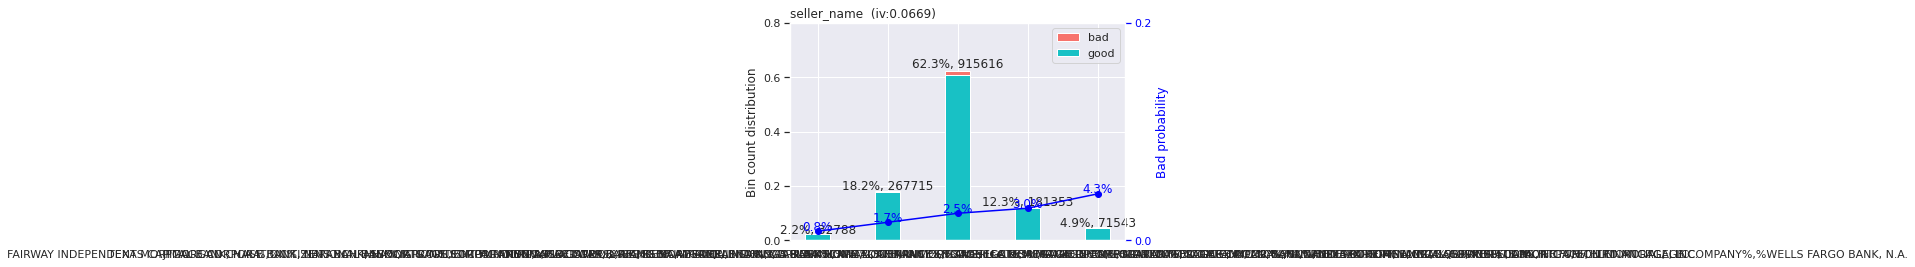

>>> Adjust breaks for (4/14) seller_name?
1: next 
2: yes 
3: back
Selection: 1
-------- 5/14 Area --------
>>> dt[Area].describe(): 
count     1469015
unique          9
top       Pacific
freq       298105
Name: Area, dtype: object 

>>> dt[Area].value_counts(): 
Pacific          298105
SouthEast        194185
TheDesert        170247
TheSouth         162932
Atlantic         158162
TheGreatLakes    155506
TheMid           128398
TheEast          109314
TheNorth          92166
Name: Area, dtype: int64 

>>> Current breaks:
'Pacific%,%TheDesert%,%TheNorth%,%Atlantic%,%TheGreatLakes%,%TheMid%,%TheEast','TheSouth','SouthEast' 



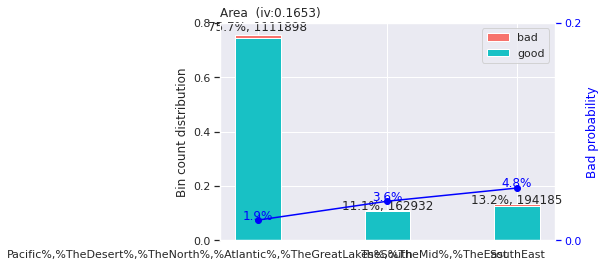

>>> Adjust breaks for (5/14) Area?
1: next 
2: yes 
3: back
Selection: 1
-------- 6/14 cnt_borr --------
>>> dt[cnt_borr].describe(): 
count   1469015.0000
mean          1.5006
std           0.5000
min           1.0000
25%           1.0000
50%           2.0000
75%           2.0000
max           2.0000
Name: cnt_borr, dtype: float64 

>>> dt[cnt_borr].value_counts(): 
2.0000    735326
1.0000    733689
Name: cnt_borr, dtype: int64 

>>> Current breaks:
2.0 



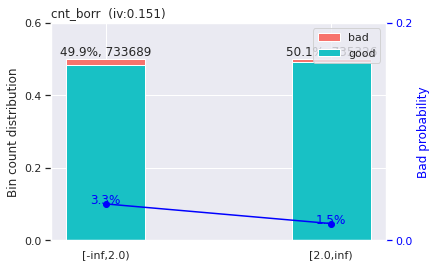

>>> Adjust breaks for (6/14) cnt_borr?
1: next 
2: yes 
3: back
Selection: 1
-------- 7/14 fico --------
>>> dt[fico].describe(): 
count   1469015.0000
mean        749.4443
std          45.2283
min         517.0000
25%         717.0000
50%         758.0000
75%         787.0000
max         845.0000
Name: fico, dtype: float64 



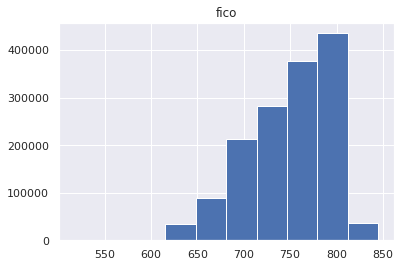

>>> Current breaks:
665.0,690.0,735.0,775.0 



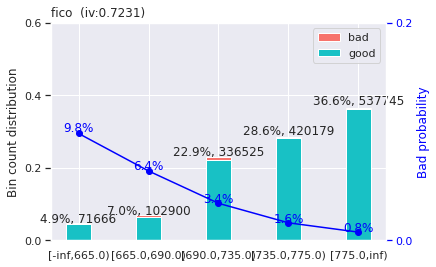

>>> Adjust breaks for (7/14) fico?
1: next 
2: yes 
3: back
Selection: 1
-------- 8/14 dti --------
>>> dt[dti].describe(): 
count   1469015.0000
mean         34.4585
std           9.4044
min           1.0000
25%          28.0000
50%          36.0000
75%          42.0000
max          51.0000
Name: dti, dtype: float64 



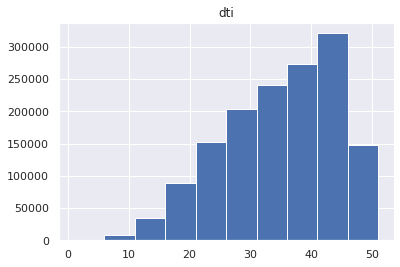

>>> Current breaks:
26.0,34.0,46.0 



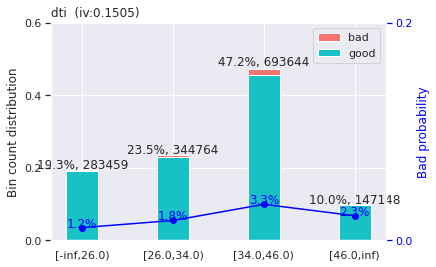

>>> Adjust breaks for (8/14) dti?
1: next 
2: yes 
3: back
Selection: 2
>>> Enter modified breaks: 20.0,30.0,40.0
[INFO] creating woe binning ...
>>> Current breaks:
40.0, 30.0, 20.0 



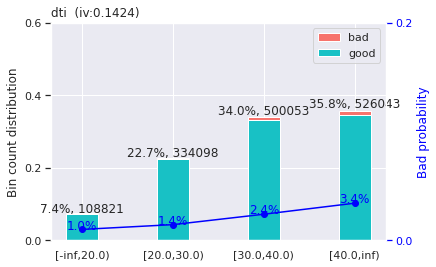

>>> Adjust breaks for (8/14) dti?
1: next 
2: yes 
3: back
Selection: 1
-------- 9/14 cnt_units --------
>>> dt[cnt_units].describe(): 
count   1469015.0000
mean          1.0322
std           0.2409
min           1.0000
25%           1.0000
50%           1.0000
75%           1.0000
max           4.0000
Name: cnt_units, dtype: float64 

>>> dt[cnt_units].value_counts(): 
1.0000    1436783
2.0000      21953
3.0000       5533
4.0000       4746
Name: cnt_units, dtype: int64 

>>> Current breaks:
2.0 



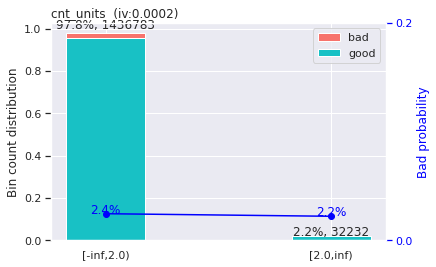

>>> Adjust breaks for (9/14) cnt_units?
1: next 
2: yes 
3: back
Selection: 1
-------- 10/14 prop_type --------
>>> dt[prop_type].describe(): 
count     1469015
unique          5
top            SF
freq       939679
Name: prop_type, dtype: object 

>>> dt[prop_type].value_counts(): 
SF    939679
PU    406558
CO    115249
MH      4957
CP      2572
Name: prop_type, dtype: int64 

>>> Current breaks:
'CP%,%CO','SF','PU%,%MH' 



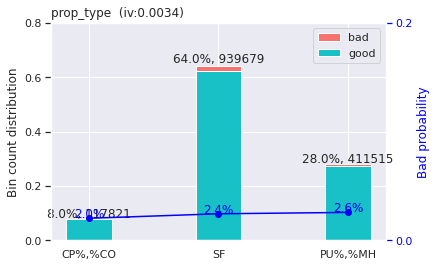

>>> Adjust breaks for (10/14) prop_type?
1: next 
2: yes 
3: back
Selection: 1
-------- 11/14 servicer_name --------
>>> dt[servicer_name].describe(): 
count             1469015
unique                 40
top       Other servicers
freq               424662
Name: servicer_name, dtype: object 

>>> dt[servicer_name].value_counts(): 
Other servicers                              424662
WELLS FARGO BANK, N.A.                       197727
JPMORGAN CHASE BANK, NATIONAL ASSOCIATION    103393
U.S. BANK N.A.                                79262
QUICKEN LOANS INC.                            75200
NEW RESIDENTIAL MORTGAGE LLC                  54855
BANK OF AMERICA, N.A.                         53392
CALIBER HOME LOANS, INC.                      53347
MATRIX FINANCIAL SERVICES CORPORATION         50703
BRANCH BANKING AND TRUST COMPANY              42327
PNC BANK, NA                                  35960
PINGORA LOAN SERVICING, LLC                   34752
SUNTRUST MORTGAGE, INC.                     

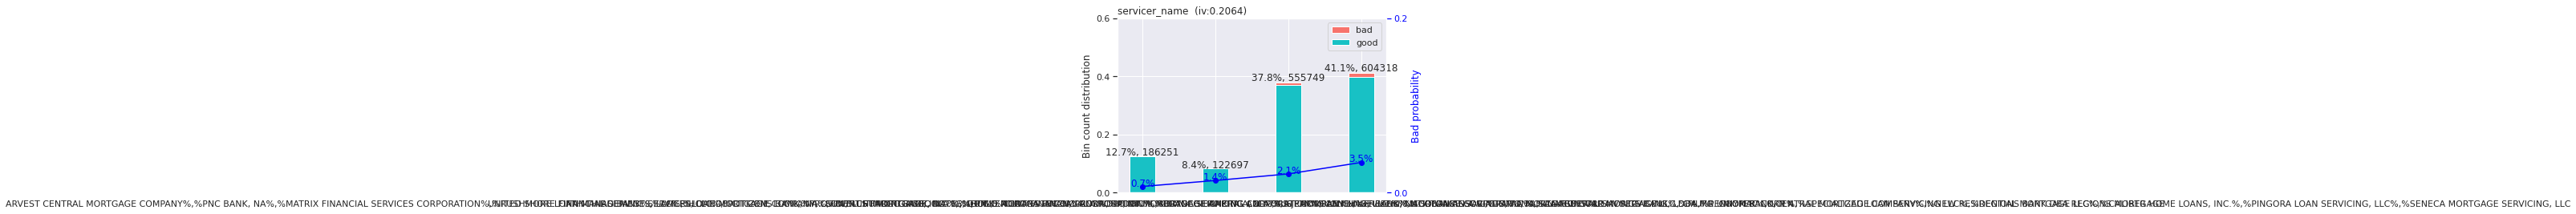

>>> Adjust breaks for (11/14) servicer_name?
1: next 
2: yes 
3: back
Selection: 1
-------- 12/14 channel --------
>>> dt[channel].describe(): 
count     1469015
unique          3
top             R
freq       841293
Name: channel, dtype: object 

>>> dt[channel].value_counts(): 
R    841293
C    479352
B    148370
Name: channel, dtype: int64 

>>> Current breaks:
'R','C','B' 



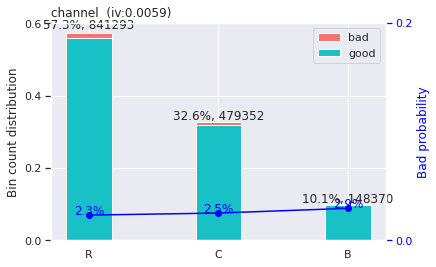

>>> Adjust breaks for (12/14) channel?
1: next 
2: yes 
3: back
Selection: 1
-------- 13/14 flag_sc --------
>>> dt[flag_sc].describe(): 
count     1469015
unique          2
top             N
freq      1408379
Name: flag_sc, dtype: object 

>>> dt[flag_sc].value_counts(): 
N    1408379
Y      60636
Name: flag_sc, dtype: int64 

>>> Current breaks:
'Y','N' 



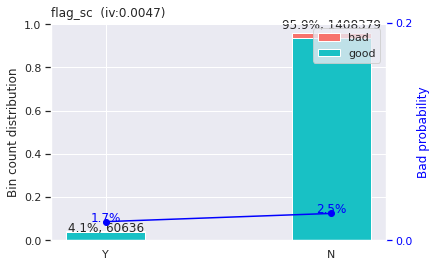

>>> Adjust breaks for (13/14) flag_sc?
1: next 
2: yes 
3: back
Selection: 1
-------- 14/14 occpy_sts --------
>>> dt[occpy_sts].describe(): 
count     1469015
unique          3
top             P
freq      1289314
Name: occpy_sts, dtype: object 

>>> dt[occpy_sts].value_counts(): 
P    1289314
I     122784
S      56917
Name: occpy_sts, dtype: int64 

>>> Current breaks:
'S','I','P' 



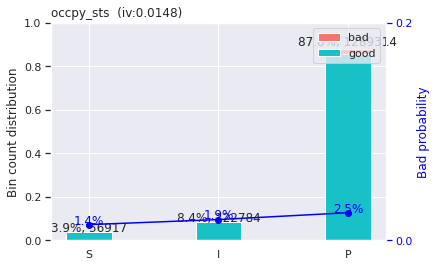

>>> Adjust breaks for (14/14) occpy_sts?
1: next 
2: yes 
3: back
Selection: 1


In [69]:
breaks_adj = sc.woebin_adj(train, "Default", bins, adj_all_var=True)

- for dti, re-adjust to 20.0,30.0,40.0

In [70]:
bins_adj = sc.woebin(train, y="Default", breaks_list=breaks_adj) # Apply new cuts

train_woe = sc.woebin_ply(train, bins_adj) # Calculate WoE dataset (train)

test_woe = sc.woebin_ply(test, bins_adj) # Calculate WoE dataset (test)

[INFO] creating woe binning ...


/opt/conda/lib/python3.8/site-packages/scorecardpy/condition_fun.py:19: UserWarning: There are 1 columns have only one unique values, which are removed from input dataset. 
 (ColumnNames: ppmt_pnlty)
  warnings.warn("There are {} columns have only one unique values, which are removed from input dataset. \n (ColumnNames: {})".format(len(unique1_cols), ', '.join(unique1_cols)))


Binning on 1469015 rows and 15 columns in 00:00:47
[INFO] converting into woe values ...
Woe transformating on 1469015 rows and 14 columns in 00:00:38
[INFO] converting into woe values ...
Woe transformating on 629578 rows and 14 columns in 00:00:19


In [71]:
breaks_adj

"{'Area': ['Pacific%,%TheDesert%,%TheNorth%,%Atlantic%,%TheGreatLakes%,%TheMid%,%TheEast','TheSouth','SouthEast'], 'channel': ['R','C','B'], 'cnt_borr': [2.0], 'cnt_units': [2.0], 'dti': [20.0,30.0,40.0], 'fico': [665.0,690.0,735.0,775.0], 'flag_fthb': ['9','N','Y'], 'flag_sc': ['Y','N'], 'loan_purpose': ['N','P','C'], 'ltv': [59.0,86.0,94.0], 'occpy_sts': ['S','I','P'], 'prop_type': ['CP%,%CO','SF','PU%,%MH'], 'seller_name': ['TEXAS CAPITAL BANK, N.A.%,%CITIZENS BANK, NA%,%PROVIDENT FUNDING ASSOCIATES, L.P.%,%USAA FEDERAL SAVINGS BANK%,%NATIONSTAR MORTGAGE LLC DBA MR. COOPER%,%GUILD MORTGAGE COMPANY%,%HOME POINT FINANCIAL CORPORATION','JPMORGAN CHASE BANK, NATIONAL ASSOCIATION%,%IMPAC MORTGAGE CORP.%,%BANK OF AMERICA, N.A.%,%U.S. BANK N.A.%,%FINANCE OF AMERICA MORTGAGE LLC%,%GUARANTEED RATE, INC.%,%SUNTRUST MORTGAGE, INC.%,%PROSPECT MORTGAGE, LLC','FAIRWAY INDEPENDENT MORTGAGE CORPORATION%,%BRANCH BANKING & TRUST COMPANY%,%FLAGSTAR BANK, FSB%,%PRIMELENDING, A PLAINSCAPITAL COMPANY%,%O

In [72]:
bins_adj

{'ltv':   variable          bin   count  count_distr    good    bad  badprob     woe  \
 0      ltv  [-inf,59.0)  245995       0.1675  242391   3604   0.0147 -0.5206   
 1      ltv  [59.0,86.0)  897008       0.6106  876500  20508   0.0229 -0.0672   
 2      ltv  [86.0,94.0)  130366       0.0887  126487   3879   0.0298  0.2034   
 3      ltv   [94.0,inf)  195646       0.1332  187775   7871   0.0402  0.5159   
 
    bin_iv  total_iv breaks  is_special_values  
 0  0.0357    0.0881   59.0              False  
 1  0.0027    0.0881   86.0              False  
 2  0.0040    0.0881   94.0              False  
 3  0.0456    0.0881    inf              False  ,
 'flag_fthb':     variable bin   count  count_distr    good    bad  badprob     woe  bin_iv  \
 0  flag_fthb   9  788874       0.5370  771437  17437   0.0221 -0.1017  0.0053   
 1  flag_fthb   N  415368       0.2828  405418   9950   0.0240 -0.0194  0.0001   
 2  flag_fthb   Y  264773       0.1802  256298   8475   0.0320  0.2787  0.0160   

In [73]:
train_woe.head()

,Default,ppmt_pnlty,ltv_woe,flag_fthb_woe,loan_purpose_woe,seller_name_woe,Area_woe,cnt_borr_woe,fico_woe,dti_woe,cnt_units_woe,prop_type_woe,servicer_name_woe,channel_woe,flag_sc_woe,occpy_sts_woe
0,0,N,-0.0672,-0.1017,0.0428,0.0178,-0.2786,-0.4711,0.3422,0.3455,0.0022,-0.0008,0.3596,-0.0536,0.0130,-0.2522
1,1,N,0.5159,0.2787,0.0428,0.0178,-0.2786,0.3247,-1.1946,-0.0181,0.0022,-0.0008,0.3596,-0.0536,0.0130,0.0391
2,0,N,-0.0672,-0.1017,0.1269,0.0178,-0.2786,0.3247,-0.4259,0.3455,0.0022,-0.0008,0.3596,-0.0536,0.0130,0.0391
3,0,N,-0.0672,-0.1017,-0.2752,0.0178,-0.2786,-0.4711,-0.4259,0.3455,0.0022,-0.0008,0.3596,-0.0536,0.0130,0.0391
4,0,N,0.2034,-0.0194,0.0428,0.0178,-0.2786,-0.4711,1.0017,-0.0181,0.0022,-0.0008,0.3596,-0.0536,0.0130,0.0391


## Information Value Filtering

Now we can check the information value of our variables and remove those who are not predictive. We use the function ```iv```. In general:

- $IV < 0.02$: No predictive ability, remove.
- $0.02 \le IV < 0.1$: Small predictive ability, suggest to remove.
- $0.1 \le IV < 0.3$: Medium predictive ability, leave.
- $0.3 \le IV < 1$: Good predictive ability, leave.
- $1 \le IV $: Strong predictive ability. Suspicious variable. Study if error in calculation (i.e. WoE leaves a category with 100% goods or bads) or if variable is capturing future information.

In [74]:
iv_table = sc.iv(train_woe, 'Default')
iv_table
# eliminate ppmt_pnlty for no predictability at all(all same data points.)

,variable,info_value
6,fico_woe,0.7231
13,servicer_name_woe,0.2064
10,Area_woe,0.1653
14,cnt_borr_woe,0.1510
12,dti_woe,0.1424
11,ltv_woe,0.0881
9,seller_name_woe,0.0669
2,flag_fthb_woe,0.0214
3,loan_purpose_woe,0.0202
0,occpy_sts_woe,0.0148


In [75]:
# Don't have too many powerful explanatory variables.
# Also spotted a jump in information value(0.08 - 0.14). 
# So to not exclude limited information, create range of accepted variables(>=0.08)

accepted_range = iv_table.loc[iv_table['info_value']>=0.08].variable.tolist()
accepted_range.append('Default')
train_woe = train_woe[accepted_range]
test_woe = test_woe[accepted_range]
train_woe.head()

,fico_woe,servicer_name_woe,Area_woe,cnt_borr_woe,dti_woe,ltv_woe,Default
0,0.3422,0.3596,-0.2786,-0.4711,0.3455,-0.0672,0
1,-1.1946,0.3596,-0.2786,0.3247,-0.0181,0.5159,1
2,-0.4259,0.3596,-0.2786,0.3247,0.3455,-0.0672,0
3,-0.4259,0.3596,-0.2786,-0.4711,0.3455,-0.0672,0
4,1.0017,0.3596,-0.2786,-0.4711,-0.0181,0.2034,0


In [76]:
# Save
np.save('bins_adj.npy', bins_adj) 

train_woe.to_csv("train_woe.csv", index = False)
test_woe.to_csv("test_woe.csv", index = False)
freddie_data[origination_cols_final].to_pickle('freddie_data.pkl')

## Step3: Construct a scorecard that models the probability of default for the loans

In [50]:
# # Load
# bins_adj = np.load('bins_adj.npy',allow_pickle='TRUE').item()

# train_woe = pd.read_csv('train_woe.csv')
# test_woe = pd.read_csv('test_woe.csv')
# freddie_data = pd.read_pickle('freddie_data.pkl')

In [77]:
# preprocess noWOE data 

origination_cols_final = ['fico', 'flag_fthb', 'cnt_units', 'occpy_sts', 'ltv',
                         'dti', 'channel', 'prop_type', 'loan_purpose', 'cnt_borr',
                         'servicer_name','seller_name', 'Area', 'flag_sc','Default'] # for noWOE data

origination_cols_final_final = ['fico', 'ltv','dti', 'cnt_borr', 'servicer_bin', 'Area', 'Default'] # for woe

# from sklearn import preprocessing

In [79]:
# ordinal categorical vars are converted to floats

ord_categ = ['cnt_units', 'cnt_borr']
freddie_data[ord_categ] = freddie_data[ord_categ].apply(pd.to_numeric) 

# for rf and xgboosting using one-hot encoding for other categ var.

freddie_data_no_WoE = pd.get_dummies(freddie_data[origination_cols_final])
col_def = freddie_data_no_WoE.pop("Default")
freddie_data_no_WoE.insert(len(freddie_data_no_WoE.columns), col_def.name, col_def)

In [80]:
freddie_data_no_WoE.head()

,fico,cnt_units,ltv,dti,cnt_borr,flag_fthb_9,flag_fthb_N,flag_fthb_Y,occpy_sts_I,occpy_sts_P,...,Area_SouthEast,Area_TheDesert,Area_TheEast,Area_TheGreatLakes,Area_TheMid,Area_TheNorth,Area_TheSouth,flag_sc_N,flag_sc_Y,Default
0,717.0000,1.0000,77.0000,41.0000,2.0000,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,813.0000,1.0000,95.0000,32.0000,1.0000,0,0,1,0,1,...,0,0,0,0,0,1,0,1,0,1
2,742.0000,1.0000,78.0000,45.0000,1.0000,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
3,735.0000,1.0000,67.0000,45.0000,2.0000,1,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
4,667.0000,1.0000,90.0000,30.0000,2.0000,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0


In [81]:
# preprocess noWOE data for rf and xgboosting using one-hot encoding.
train_noWoE, test_noWoE = sc.split_df(freddie_data_no_WoE,
                          y = 'Default',
                          ratio = 0.7, 
                          seed = 251121229).values()

<AxesSubplot:>

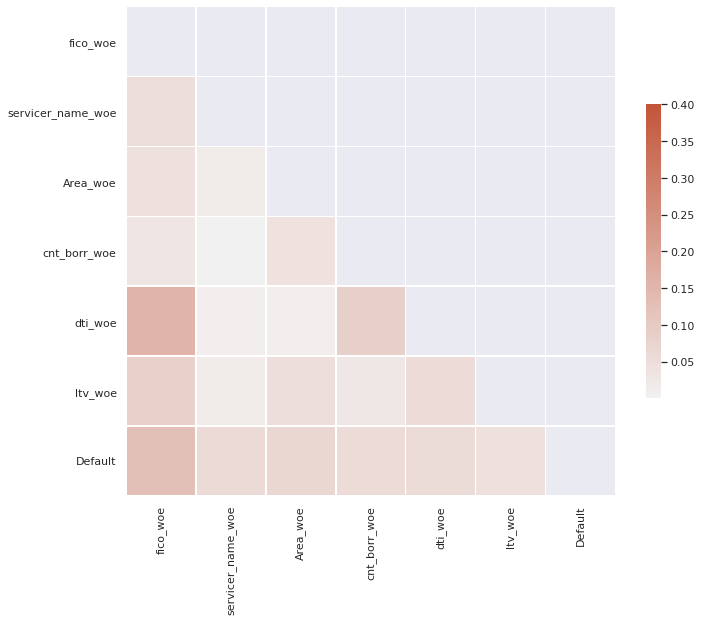

In [84]:
corr = train_woe.corr(method='spearman')
corr = np.abs(corr)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4, center=0,
            square=True, linewidths=.4, cbar_kws={"shrink": .6})

There are no apparent variables that are highly correlated, the highest spearman correlation found is  0.1581 between dti_woe and fico_woe. In a logistic regression, all coefficients should be positive, otherwise there are correlations effects at play.

In [85]:
%%time
freddie_data_logreg_CV = LogisticRegressionCV(penalty='l1', # Type of penalization l1 = lasso, l2 = ridge
                                     Cs = 10, # 10 lambdas to try
                                     tol=0.0001, # Tolerance for parameters
                                     cv = 3, # 3 folds to train
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     max_iter=100, # Maximum iterations
                                     verbose=1, # Show process. 1 is yes.
                                     solver = 'liblinear',
                                     n_jobs = 12,
                                     refit = True
                                    )

CPU times: user 28 µs, sys: 1e+03 ns, total: 29 µs
Wall time: 32.2 µs


In [86]:
%%time
freddie_data_logreg_CV.fit(X = train_woe.iloc[:, :-1], # All rows and from the first var to second last
                    y = train_woe['Default'] # The target
                   )

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of   3 | elapsed:   10.9s finished


CPU times: user 1.66 s, sys: 580 ms, total: 2.24 s
Wall time: 12.8 s


LogisticRegressionCV(class_weight='balanced', cv=3, n_jobs=12, penalty='l1',
                     solver='liblinear', verbose=1)

In [87]:
freddie_data_logreg_CV.C_[0]

0.046415888336127774

In [88]:
freddie_data_logreg_CV.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [89]:
%%time
freddie_data_logreg = LogisticRegression(penalty='l1', # Type of penalization l1 = lasso, l2 = ridge
                                     tol=0.0001, # Tolerance for parameters
                                     C=freddie_data_logreg_CV.C_[0], # Penalty constant from CV
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
#                                      random_state=251121229, # Random seed
                                     max_iter=500, # Maximum iterations
                                     verbose=1, # Show process. 1 is yes.
                                     solver = 'liblinear',
                                     n_jobs = 12,
                                     warm_start=True # Train anew or start from previous weights. For repeated training. 
                                    ) # explain why theres abnormal high WOE values

CPU times: user 36 µs, sys: 1e+03 ns, total: 37 µs
Wall time: 41.5 µs


In [62]:
# explaining the lambda

In [90]:
%%time
freddie_data_logreg.fit(X = train_woe.iloc[:, :-1], # All rows and from the second var to end
                    y = train_woe['Default'] # The target
                   )

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear]CPU times: user 944 ms, sys: 129 ms, total: 1.07 s
Wall time: 1.07 s


LogisticRegression(C=0.046415888336127774, class_weight='balanced',
                   max_iter=500, n_jobs=12, penalty='l1', solver='liblinear',
                   verbose=1, warm_start=True)

In [91]:
coef_df = pd.concat([pd.DataFrame({'column': train_woe.columns[:-1]}), 
                    pd.DataFrame(np.transpose(freddie_data_logreg.coef_))],
                    axis = 1
                   )

coef_df

,column,0
0,fico_woe,0.9750
1,servicer_name_woe,0.9223
2,Area_woe,0.9003
3,cnt_borr_woe,1.1250
4,dti_woe,0.6920
5,ltv_woe,0.8319


## Applying to the test set

We can now apply our results to the test set, and check our results. Most models in scikit-learn have the ```predict``` method which applies the model to new data, this gives the 0-1 prediction. Alternatively (and more usefully) we can use the ```predict_proba``` method that gives the probability.

In [92]:
pred_class_test = freddie_data_logreg.predict(test_woe.iloc[:, :-1])
probs_test = freddie_data_logreg.predict_proba(test_woe.iloc[:, :-1])
print(probs_test[0:5], pred_class_test[0:5])

[[0.57685601 0.42314399]
 [0.39167632 0.60832368]
 [0.27281792 0.72718208]
 [0.58339761 0.41660239]
 [0.33348407 0.66651593]] [0 1 1 0 1]


In [93]:
from sklearn.metrics import confusion_matrix

In [94]:
confusion_matrix(y_true = test_woe['Default'], y_pred = pred_class_test)

array([[439349, 174860],
       [  3982,  11387]])

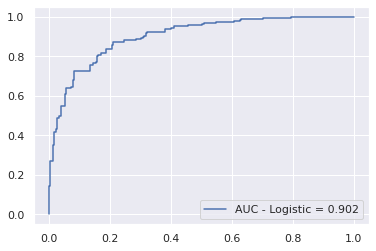

In [200]:
# Predict probabilities of scorecard.
logreg_probs_test = freddie_data_logreg.predict_proba(test_woe.iloc[:, 1:])

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_woe['Default'], 
                                 logreg_probs_test[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_woe['Default'], 
                             y_score = logreg_probs_test[:,1]),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - Logistic = " + str(auc))
plt.legend(loc=4)
plt.show()

## Scorecards

The package ```scorecardpy``` has the function ```scorecard``` which receives a trained logistic regression model trained over WoE-transformed data, a trained scorecard **over the same variables** and a list of matched columns (that is, the order of columns in the scorecard). As optional arguments it receives a PDO, a base score, and decimal base odds (so instead of 50:1, it receives 0.02).

You should adjust these values so the score is in a range that's acceptable. Typically between 0 and 1000.

In [95]:
freddie_data_sc = sc.scorecard(bins_adj, freddie_data_logreg, 
             train_woe.columns[:-1], # The column names in the trained LR
             points0=750, # Base points
             odds0=0.01, # Base odds
             pdo=50) # PDO 
freddie_data_sc

{'basepoints':      variable  bin  points
 0  basepoints  nan     419,
 'fico':    variable            bin    points
 20     fico   [-inf,665.0) -103.0000
 21     fico  [665.0,690.0)  -70.0000
 22     fico  [690.0,735.0)  -24.0000
 23     fico  [735.0,775.0)   30.0000
 24     fico    [775.0,inf)   84.0000,
 'servicer_name':          variable                                                bin   points
 34  servicer_name  UNITED SHORE FINANCIAL SERVICES, LLC%,%LOANDEP...  83.0000
 35  servicer_name  SUNTRUST MORTGAGE, INC.%,%GUILD MORTGAGE COMPA...  38.0000
 36  servicer_name  ARVEST CENTRAL MORTGAGE COMPANY%,%PNC BANK, NA...   9.0000
 37  servicer_name  FIFTH THIRD BANK%,%AMERIHOME MORTGAGE COMPANY,... -24.0000,
 'Area':    variable                                                bin   points
 15     Area  Pacific%,%TheDesert%,%TheNorth%,%Atlantic%,%Th...  18.0000
 16     Area                                           TheSouth -26.0000
 17     Area                                        

In [106]:
# Applying the credit score. Applies over the original data!
train_score = sc.scorecard_ply(train[['fico', 'ltv','dti', 'cnt_borr', 
                                           'servicer_name', 'Area', 'Default']], freddie_data_sc, 
                               print_step=0)
test_score = sc.scorecard_ply(test[['fico', 'ltv','dti', 'cnt_borr', 
                                         'servicer_name', 'Area', 'Default']], freddie_data_sc, 
                               print_step=0)

In [107]:
train_score.describe()

,score
count,1469015.0000
mean,466.9950
std,88.7751
min,172.0000
25%,404.0000
50%,468.0000
75%,529.0000
max,718.0000


## Step 4: Use XGBoosting model and Random Forest model trained over the data without the WoE transformation. Compare with Scorecard model.

In [108]:
import inspect
inspect.getfullargspec(sc.scorecard)

FullArgSpec(args=['bins', 'model', 'xcolumns', 'points0', 'odds0', 'pdo', 'basepoints_eq0'], varargs=None, varkw=None, defaults=(600, 0.05263157894736842, 50, False), kwonlyargs=[], kwonlydefaults=None, annotations={})

In [218]:
pd.concat([train_score, test_score]).sort_index(axis = 0)

,score
0,414.0000
1,441.0000
2,404.0000
3,468.0000
4,370.0000
...,...
2098588,673.0000
2098589,386.0000
2098590,520.0000
2098591,358.0000


In [201]:
from sklearn.ensemble import RandomForestClassifier

#Define the classifier
freddie_data_rf = RandomForestClassifier(n_estimators=100, # Number of trees to train #/100~largest 10s
                       criterion='entropy', # How to train the trees. Also supports gini.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.0001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='auto', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-4.
                       bootstrap=False, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=False,  # If report accuracy with non-selected cases.
                       n_jobs=12, # Parallel processing. Set to the number of cores you have. Watch your RAM!!
                       random_state=251121229, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced' # Balance the classes.
                                    )

In [129]:
from sklearn.metrics import roc_curve, auc
def n_estimators_tune(): 
    n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
    train_results = []
    test_results = []
    x_train = train_noWoE.iloc[:,:-1]
    y_train = train_noWoE['Default']
    x_test = test_noWoE.iloc[:,:-1]
    y_test = test_noWoE['Default']
    for estimator in n_estimators:
       rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
       rf.fit(x_train, y_train)
       train_pred = rf.predict(x_train)
       false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
       roc_auc = auc(false_positive_rate, true_positive_rate)
       train_results.append(roc_auc)
       y_pred = rf.predict(x_test)
       false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
       roc_auc = auc(false_positive_rate, true_positive_rate)
       test_results.append(roc_auc)
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
    line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('n_estimators')
    plt.show()

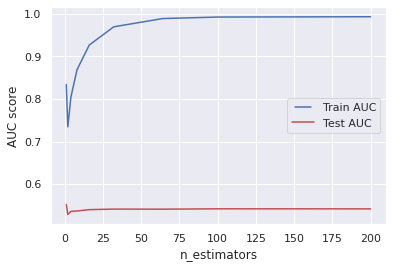

In [130]:
n_estimators_tune()

In [202]:
%%time
# Train the RF.
freddie_data_rf.fit(train_noWoE.iloc[:,:-1], # X 
               train_noWoE['Default']    # y
                )

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   17.5s


CPU times: user 9min 46s, sys: 892 ms, total: 9min 47s
Wall time: 51.7 s


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   50.8s finished


RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', min_impurity_decrease=0.0001,
                       min_samples_leaf=0.0001, n_jobs=12,
                       random_state=251121229, verbose=1)

In [203]:
import pickle
pkl_filename = 'freddie_data_rf.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(freddie_data_rf, file)
 

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))


In [204]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

# Apply the model to the test set.
rf_pred_class_test = freddie_data_rf.predict(test_noWoE.iloc[:, :-1])
rf_probs_test = freddie_data_rf.predict_proba(test_noWoE.iloc[:, :-1])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.7s finished


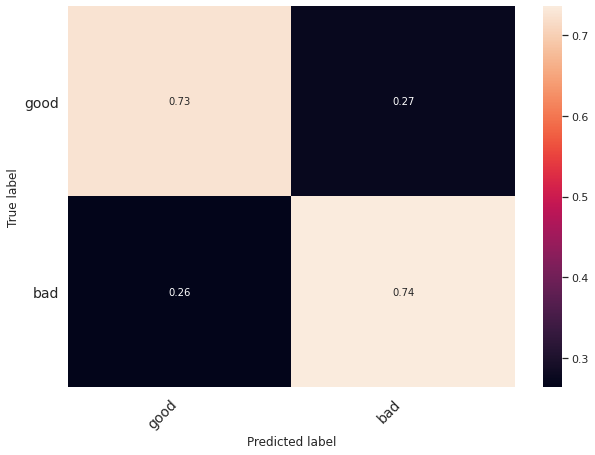

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Calculate confusion matrix
confusion_matrix_rf = confusion_matrix(y_true = test_noWoE['Default'], 
                    y_pred = rf_pred_class_test)

# Turn matrix to percentages
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_rf, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

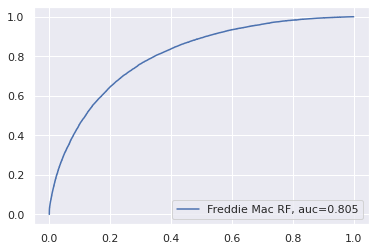

In [206]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_noWoE['Default'], rf_probs_test[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_noWoE['Default'], 
                             y_score = rf_probs_test[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Freddie Mac RF, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [117]:
train_noWoE.iloc[:, :-1].columns

Index(['fico', 'cnt_units', 'ltv', 'dti', 'cnt_borr', 'flag_fthb_9',
       'flag_fthb_N', 'flag_fthb_Y', 'occpy_sts_I', 'occpy_sts_P',
       ...
       'Area_Pacific', 'Area_SouthEast', 'Area_TheDesert', 'Area_TheEast',
       'Area_TheGreatLakes', 'Area_TheMid', 'Area_TheNorth', 'Area_TheSouth',
       'flag_sc_N', 'flag_sc_Y'],
      dtype='object', length=112)

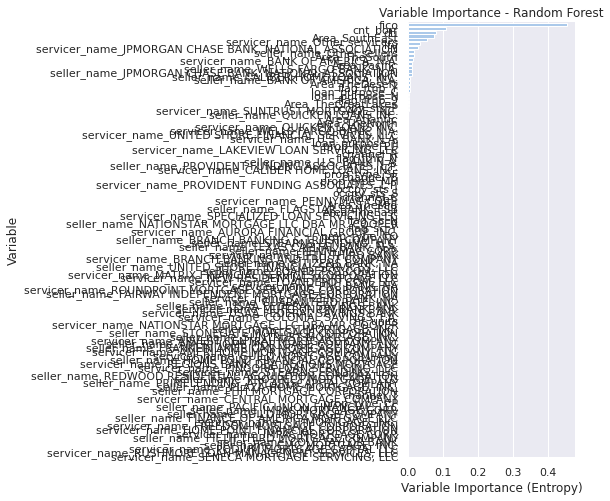

In [207]:
# Plot variable importance
importances = freddie_data_rf.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - Random Forest")
sns.set_color_codes("pastel")
sns.barplot(y=[train_noWoE.iloc[:, :-1].columns[i] for i in indices], 
            x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

In [183]:
!pip install xgboost
from xgboost import XGBClassifier
#Define the classifier.
XGB_Freddie = XGBClassifier(max_depth=3,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=12,                    # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=40,           # Balancing of positive and negative weights. 
                                                          # should be set to the positive case balancing weight, or #Goods / #Bads.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=251121229,       # Seed
                            missing=None                  # How are nulls encoded?
                            )

In [182]:
test_noWoE.groupby('Default').count()
# # of goods / # of bads is around 40

,fico,cnt_units,ltv,dti,cnt_borr,flag_fthb_9,flag_fthb_N,flag_fthb_Y,occpy_sts_I,occpy_sts_P,...,Area_Pacific,Area_SouthEast,Area_TheDesert,Area_TheEast,Area_TheGreatLakes,Area_TheMid,Area_TheNorth,Area_TheSouth,flag_sc_N,flag_sc_Y
Default,,,,,,,,,,,,,,,,,,,,,
0,614209,614209,614209,614209,614209,614209,614209,614209,614209,614209,...,614209,614209,614209,614209,614209,614209,614209,614209,614209,614209
1,15369,15369,15369,15369,15369,15369,15369,15369,15369,15369,...,15369,15369,15369,15369,15369,15369,15369,15369,15369,15369


In [184]:
# Define the parameters. Play with this grid!
param_grid = dict({'n_estimators': [50, 100, 150],
                   'max_depth': [2, 3, 4],
                 'learning_rate' : [0.01, 0.05, 0.1, 0.15]
                  })

# Always a good idea to tune on a reduce sample of the train set, as we will call many functions.
val_train = train_noWoE.sample(frac = 0.05,               # The fraction to extract
                                       random_state = 251121229,    # The seed.
                                       )

In [185]:
from sklearn.model_selection import GridSearchCV

# Define grid search object.
GridXGB = GridSearchCV(XGB_Freddie,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross-validation folds.  
                       scoring = 'roc_auc', # How to rank outputs.
                       n_jobs = 12,          # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

In [186]:
# Train grid search.
GridXGB.fit(val_train.iloc[:, :-1], val_train['Default'])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 108 out of 108 | elapsed: 47.8min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0.001,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=None,
                                     missing=None, monotone_constraints=None,
                                     n_estimators=100, n_jobs=12,
                                     num_parallel_tree=None,
                                     random_state=20201108, reg_alpha=1,
                                     reg_lambda=0, scale_pos_weight=40,
                                     subsample=0.632, tree_method=None,
                                     validate_par

In [210]:
import pickle
pkl_filename = 'freddie_data_xgb_cv.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(GridXGB, file)
 

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [187]:
# Show best params
GridXGB.best_score_

0.8080742010664719

In [211]:
GridXGB.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}

In [188]:
XGB_Freddie = XGBClassifier(max_depth=GridXGB.best_params_.get('max_depth'), # Depth of each tree
                            learning_rate=GridXGB.best_params_.get('learning_rate'), # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=GridXGB.best_params_.get('n_estimators'), # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=12,                    # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=40,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=251121229,       # Seed
                            missing=None                  # How are nulls encoded?
                            )

In [189]:
%%time
# Train over all training data.
XGB_Freddie.fit(train_noWoE.iloc[:, :-1], train_noWoE['Default'])

CPU times: user 13min 52s, sys: 1.59 s, total: 13min 53s
Wall time: 1min 13s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=150, n_jobs=12, num_parallel_tree=1,
              random_state=251121229, reg_alpha=1, reg_lambda=0,
              scale_pos_weight=40, subsample=0.632, tree_method='exact',
              validate_parameters=1, verbosity=1)

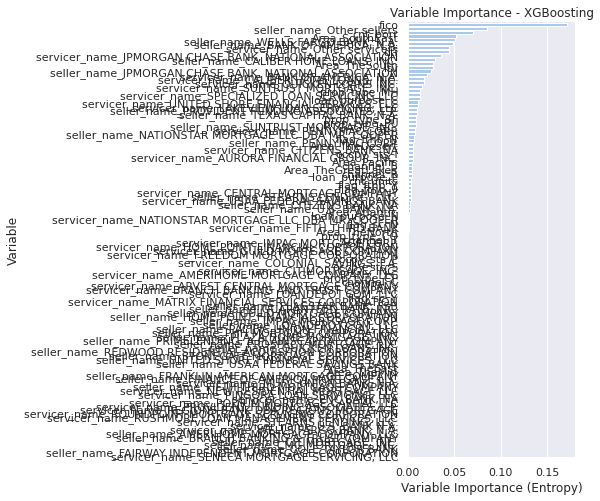

In [190]:
# Plot variable importance
importances = XGB_Freddie.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[train_noWoE.iloc[:, :-1].columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

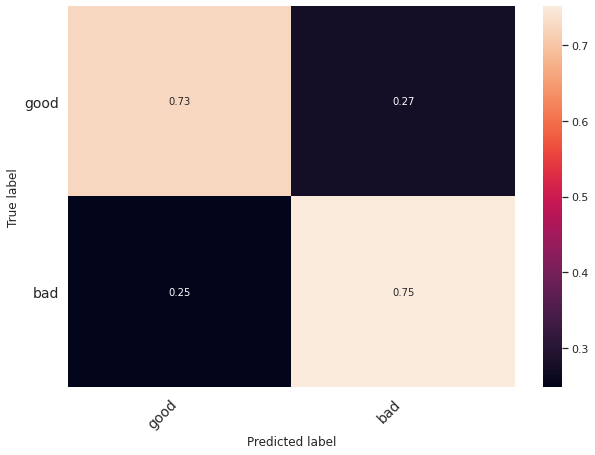

In [191]:
# Calculate probability
XGBClassTest = XGB_Freddie.predict(test_noWoE.iloc[:, :-1])
xg_probs_test = XGB_Freddie.predict_proba(test_noWoE.iloc[:, :-1])
xg_probs_test = xg_probs_test[:, 1]

# Calculate confusion matrix
confusion_matrix_xgb = confusion_matrix(y_true = test_noWoE['Default'], 
                    y_pred = XGBClassTest)

# Turn matrix to percentages
confusion_matrix_xgb = confusion_matrix_xgb.astype('float') / confusion_matrix_xgb.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_xgb, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

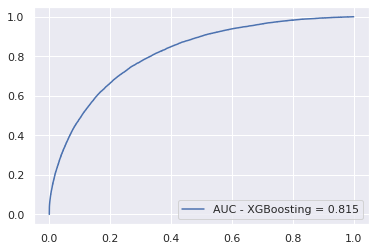

In [192]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_noWoE['Default'], 
                                 xg_probs_test)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_noWoE['Default'], 
                             y_score = xg_probs_test),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()

In [193]:
# Predict probabilities of scorecard.
logreg_probs_test = freddie_data_logreg.predict_proba(test_woe.iloc[:, 1:])

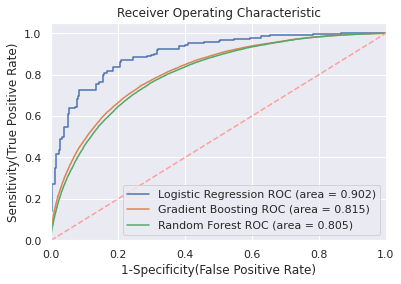

In [208]:
# Set models and probabilities. This structure is called a dictionary.
models = [
{
    'label': 'Logistic Regression',
    'probs': logreg_probs_test[:,1]
},
{
    'label': 'Gradient Boosting',
    'probs': xg_probs_test
},
{
    'label': 'Random Forest',
    'probs': rf_probs_test[:,1]
}
]

# Loop that creates the plot. I will pass each ROC curve one by one.
for m in models:
  auc = roc_auc_score(y_true = test_noWoE['Default'], 
                             y_score = m['probs'])
  fpr, tpr, thresholds = roc_curve(test_woe['Default'], 
                                           m['probs'])
  plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % (m['label'], auc))
                 

    
# Settings
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
    
# Plot!    
plt.show()

## Step 5: Comparevariable importance

In [225]:
df_p5 = freddie_data.merge(pd.concat([train_score, test_score]).sort_index(axis = 0), 
                           how='left',left_index=True, right_index=True)

df_p5 = df_p5.drop(columns=['fico', 'flag_fthb', 
       'cd_msa', 'mi_pct', 'cnt_units', 'occpy_sts', 'cltv', 'dti', 
       'ltv', 'channel', 'ppmt_pnlty', 'prod_type', 'st',
       'prop_type', 'zipcode', 'loan_purpose', 'cnt_borr',
       'seller_name', 'servicer_name', 'flag_sc', 'Area'])

In [246]:
df_p5.to_csv('df_p5.csv')

In [3]:
df_p5 = pd.read_csv('df_p5.csv')

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (11,14,15,17,20,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [124]:
cut_list = np.arange(150, 800, 25)[::-1]
cut_list.tolist()

[775,
 750,
 725,
 700,
 675,
 650,
 625,
 600,
 575,
 550,
 525,
 500,
 475,
 450,
 425,
 400,
 375,
 350,
 325,
 300,
 275,
 250,
 225,
 200,
 175,
 150]

In [125]:
%time
Accepted_list = [df_p5.loc[df_p5['score'] >= q]['Default'].count() / len(df_p5)
    for q in cut_list]
Rejected_list = bad_r_list = [df_p5.loc[df_p5['score'] < q]['Default'].count() / len(df_p5)
    for q in cut_list]
sensitivity_list = [1-(df_p5.loc[df_p5['score'] >= q]['Default'].sum() / len(df_p5.loc[df_p5['score'] >= q]))
    for q in cut_list] # predicted good is good
specificity_list = [df_p5.loc[df_p5['score'] < q]['Default'].sum() / len(df_p5.loc[df_p5['score'] < q])
    for q in cut_list] # predicted bad is bad
one_minus_specificity_list = [1 - x for x in specificity_list]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


<ipython-input-125-960aab6b53ab>:6: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity_list = [1-(df_p5.loc[df_p5['score'] >= q]['Default'].sum() / len(df_p5.loc[df_p5['score'] >= q]))
<ipython-input-125-960aab6b53ab>:6: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity_list = [1-(df_p5.loc[df_p5['score'] >= q]['Default'].sum() / len(df_p5.loc[df_p5['score'] >= q]))
<ipython-input-125-960aab6b53ab>:6: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity_list = [1-(df_p5.loc[df_p5['score'] >= q]['Default'].sum() / len(df_p5.loc[df_p5['score'] >= q]))
<ipython-input-125-960aab6b53ab>:8: RuntimeWarning: invalid value encountered in long_scalars
  specificity_list = [df_p5.loc[df_p5['score'] < q]['Default'].sum() / len(df_p5.loc[df_p5['score'] < q])


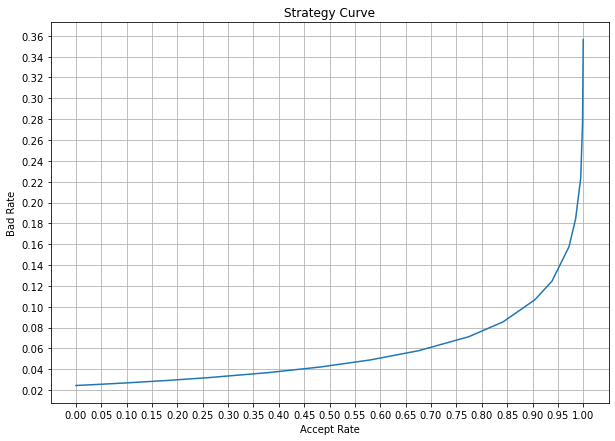

In [126]:
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(Accepted_list, specificity_list)
ax.locator_params(nbins=38, axis='x')
ax.locator_params(nbins=20, axis='y')
ax.set(xlabel='Accept Rate', ylabel='Bad Rate',
       title='Strategy Curve')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
ax.grid()

# fig.savefig("test.png")
plt.show()

In [103]:
df_p5['MnlyPMT'] = df_p5['orig_upb'] * df_p5['int_rt']/1200 *  \
                   (1+df_p5['int_rt']/1200)**df_p5['orig_loan_term']/ \
                   ((1+df_p5['int_rt']/1200)**df_p5['orig_loan_term']-1)
df_p5.loc[df_p5['Default'] == 1, 'RAROC'] = -1 * df_p5['current_upb']

df_p5.loc[df_p5['Default'] == 0, 'RAROC'] = df_p5['orig_loan_term'] * df_p5['MnlyPMT'] - df_p5['orig_upb']

In [127]:
RAROC_avg = [df_p5.loc[df_p5['score'] >= q]['RAROC'].mean()
    for q in cut_list]
RAROC_avg

[nan,
 nan,
 nan,
 103333.8103232552,
 117808.89855043154,
 129339.52991948076,
 139621.97121595766,
 139506.71971709683,
 144731.6192164413,
 150327.10226486548,
 151453.0277645846,
 154623.83516983836,
 155947.2146772324,
 157320.23831702126,
 157807.18793037086,
 157861.2211137137,
 157233.0650880167,
 156530.3681848176,
 155672.0375081517,
 154574.26565174767,
 153925.46742495953,
 153349.27001282008,
 153073.49067100152,
 152970.16982367795,
 152952.2015381735,
 152947.508826416]

In [128]:
table_5 = pd.DataFrame([cut_list.tolist(), Accepted_list, Rejected_list, 
                        sensitivity_list, one_minus_specificity_list, specificity_list, RAROC_avg])
table_5 = table_5.T
table_5.columns = ['Cutoff', 'Accepted', 'Rejected', 'Sensitivity',
                   '1-Specificity', 'Specificity', 'Avg_RAROC']
table_5 = table_5.fillna(0)
table_5

,Cutoff,Accepted,Rejected,Sensitivity,1-Specificity,Specificity,Avg_RAROC
0,775.0,0.000000,1.000000,0.000000,0.975588,0.024412,0.000000
1,750.0,0.000000,1.000000,0.000000,0.975588,0.024412,0.000000
2,725.0,0.000000,1.000000,0.000000,0.975588,0.024412,0.000000
3,700.0,0.002984,0.997016,0.999361,0.975517,0.024483,103333.810323
4,675.0,0.004454,0.995546,0.999144,0.975483,0.024517,117808.898550
5,650.0,0.014531,0.985469,0.999246,0.975239,0.024761,129339.529919
6,625.0,0.037046,0.962954,0.998791,0.974695,0.025305,139621.971216
7,600.0,0.064387,0.935613,0.998549,0.974008,0.025992,139506.719717
8,575.0,0.111512,0.888488,0.998167,0.972754,0.027246,144731.619216
9,550.0,0.179654,0.820346,0.997666,0.970753,0.029247,150327.102265


In [130]:
df_p5.loc[(df_p5['score'] >= 375) & (df_p5['score'] < 400)]['RAROC'].count() / len(df_p5)

0.0677353827064133